
# 1. Descrição do Problema
O Green Peace, em colaboração com universidades dos três continentes do globo, realizou treze tipos de análise nos três principais oceanos a fim de tentar caracterizar o perfil físico-químico de suas águas. Eles acreditam que, dada uma amostra de água, podem identificar sua origem com base nestas treze informações.
Considere-se contratado para este trabalho. Ou seja, seu grupo deve ajudar o Green Peace e desenvolver um sistema capaz de realizar a identificação da origem de uma amostra de água do mar.

# 2. Dados

Propriedade

P1	Água, gelo e vapor: Capacidade térmica e temperaturas de vaporização e fusão

P2	Água, gelo e vapor: Densidade da água

P3	Água, gelo e vapor: Densidade do gelo

P4	Água, gelo e vapor: Miscibilidade e condensação

P5	Água, gelo e vapor: Pressões de vapor da água

P6	Água, gelo e vapor: Compressibilidade

P7	Água, gelo e vapor: Ponto triplo

P8	Água, gelo e vapor: O efeito Mpemba

P9	Água, gelo e vapor: Gelo quente

P10	Tensão superficial

P11	Condutividade elétrica

P12	A natureza bipolar da água: Adesão

P13	A natureza bipolar da água: Tensão superficial
	
	Origem
	Atlântico
	Pacífico
	Índico
    
    


# 3. Solução do Problema


#### Importing libraries

Important libraries:
* NUMPY
* SKLEARN
* PANDAS
* MATPLOTLIB

In [24]:
import pandas as pd
import numpy as np

from sklearn.cross_validation import cross_val_score
# Setting k for k-fold cross-validation = 10
cross_val_k = 10

### Importing data

In [54]:
X = pd.read_csv('AM_PROBLEMA_ÁGUAOCEANOS_DADOS.txt', sep="\t", header=0, usecols=range(13), thousands=',')
Y = pd.read_csv('AM_PROBLEMA_ÁGUAOCEANOS_DADOS.txt', sep="\t", header=0, usecols=[13], encoding='latin1')
Y = Y.replace({'Pacfico': 0}, regex=True)
Y = Y.replace({'Atlntico': 1}, regex=True)
Y = Y.replace({'êndico': 2}, regex=True)

X = X.values.astype(np.float64)
Y = Y.values[:,0].astype(np.float64)

# If necessary normalize and standardize the data attributes...
from sklearn import preprocessing
# standardize and normalize the data attributes
X_NORMAL = preprocessing.normalize(X)
X_STD = preprocessing.scale(X)
X_NORMAL_STD = preprocessing.scale(X_NORMAL)


## Manipulating the Data Matrix (features)

### 1. SVD

Computing SVD to check for linearly dependent features and/or dimensionality reduction. The new data matrix is given by X_EDITED.

In [58]:
U, s, V = np.linalg.svd(X, full_matrices=True)

#print("---------U---------")
#print(U)
print("----------S--------")
print(s)
#print("----------V--------")
#print(V)

----------S--------
[ 20483.74463883   4392.65419359   3514.80082409   1945.37192771
   1791.76626242   1410.31660422   1208.09000094   1170.58281547
   1023.68619966    903.02829022    695.71101102    270.68984817
    206.47702501]


Setting SVD rank, removing singular values

In [72]:
s_rank = 12
S = np.zeros(X.shape, dtype=complex)
S[:s_rank, :s_rank] = np.diag(s)[:s_rank, :s_rank]

X_SVD = np.dot(U, np.dot(S, V));
X_SVD = np.real(X_SVD);

### 2. Removing Specific Columns
Use this to check whether the prediction gets better if some features are removed. The new data matrix is given by X_EDITED.

In [73]:
# All columns = [0,1,2,3,4,5,6,7,8,9,10,11,12]

used_columns = [1,6,10,11,12]
X_EDITED = X[:, used_columns]

### 3. KPCA / PCA
We tested different kernels, the best was the linear one. So the KPCA is being used as PCA. Transformed data matrix is given by X_KPCA.

In [74]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=9, kernel='linear')
X_KPCA = kpca.fit_transform(X)

## SVM

In [75]:
from sklearn import svm

#Penalty parameter C of the error term.
Penalty_C = 1.0  # SVM regularization parameter

#### Polynomial Kernel with degree 3

In [76]:
poly_svc = svm.SVC(kernel='poly', degree=3, C=Penalty_C)
accuracy_poly_svc = cross_val_score(poly_svc, X_KPCA, Y, cv=cross_val_k, scoring='accuracy').mean()
print('poly_svc', accuracy_poly_svc)

poly_svc 0.92138372893


### Classification accuracy 

#### Using All features + cubic order kernel
- poly_svc (degree=3) 0.899092707258

#### Removing features:
- feature 0 removed: 0.910898262814
- feature 1 removed: 0.872301771586
- feature 2 removed: 0.898800309598
- feature 3 removed: 0.893829549364
- feature 4 removed: 0.894523993808
- feature 5 removed: 0.917107413141
- feature 6 removed: 0.893244754042
- feature 7 removed: 0.910898262814
- feature 8 removed: 0.894523993808
- feature 9 removed: 0.909911420709
- feature 10 removed: 0.864445734434
- feature 11 removed: 0.89342750258
- feature 12 removed: 0.777631578947
- features [5,7] or [5,0] removed: 0.917107413141


- Using 1,6,10,11,12 -> 0.910238218094


- Worst feature: 5
- Best features: 12, 10, 1, 6, 11, 3

#### KPCA and SVD:

- PCA (KPCA with linear Kernel), using 9 components: 0.92138372893
- X_SVD with 12 singularvalues: 0.910898262814 -> Same accuracy as removing feature 0 and/or feature 7.
 
 

### SVM with different Kernels

In general, the following Kernels resulted in a worse results than the Polynomial Kernel with degree 3

#### Linear Kernel

In [77]:
# SVC with linear kernel
svc = svm.SVC(kernel='linear', C=Penalty_C)
accuracy_svc = cross_val_score(svc, X, Y, cv=cross_val_k, scoring='accuracy').mean()
print('svm linear kernel:', accuracy_svc)

svm linear kernel: 0.86477253182


#### RBF Kernel

In [78]:
rbf_svc = svm.SVC(kernel='rbf', gamma='auto', C=Penalty_C)
accuracy_rbf_svc = cross_val_score(rbf_svc, X, Y, cv=cross_val_k, scoring='accuracy').mean()
print('rbf_svc', accuracy_rbf_svc)

rbf_svc 0.399253955968


#### Polynomial Kernel with degree 2

In [79]:
poly_svc = svm.SVC(kernel='poly', degree=2, C=Penalty_C)
accuracy_poly_svc = cross_val_score(poly_svc, X, Y, cv=cross_val_k, scoring='accuracy').mean()
print('poly_svc', accuracy_poly_svc)

poly_svc 0.899092707258


##  Boosting

The best classifier we tested was Boosting.

In [62]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=1, random_state=0)
accuracy_boost = cross_val_score(model, X, Y, cv=cross_val_k, scoring='accuracy').mean()
print('boosting', accuracy_boost)

# AdaBoostClassifier - Worse
# AdaBoostClassifier(svm.SVC(probability=True,kernel='linear'),n_estimators=50, learning_rate=1.0, algorithm='SAMME')

boosting 0.971785775714


### Classification accuracy 

* All features, n_estimators = 50

0.971785775714

* Removing feature 5

0.971785775714

* Removing features 5 and 7

0.971785775714

* Using only features [1,6,10,11,12]

0.938050395597

## KNN
Algoritmo K-nearest neighbors

In [43]:
from sklearn.neighbors import KNeighborsClassifier

# Get best k.

k_range = range(1,31)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, Y, cv=cross_val_k, scoring='accuracy')
    k_scores.append(scores.mean())
#print(k_scores)
max_score = max(k_scores)
print("Best k = " , (k_scores.index(max_score) + 1))
print("Score = " , (max_score ))


Best k =  3
Score =  0.944668042656


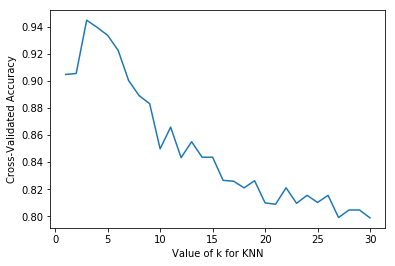

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_range, k_scores)
plt.xlabel('Value of k for KNN')
plt.ylabel('Cross-Validated Accuracy')

### Classification accuracy 

* N=3

0.944668042656

* N=3, + SVD with 12 singular values (removing 1).

0.950550395597

* N=3, + Removing feature 5.

0.955779153767

* N=4, + Removing feature 5 and 7.

0.956398348813

## Decision Tree

In [48]:
from sklearn import tree

dec_tree = tree.DecisionTreeClassifier()
accuracy_dec_tree = cross_val_score(dec_tree, X, Y, cv=cross_val_k, scoring='accuracy')
print('Decision Tree: ', accuracy_dec_tree.mean())

Decision Tree:  0.858999828001


Decision Tree Accuracy: 0.858999828001